In [90]:
import tensorflow as tf
print("🚀 Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

🚀 Num GPUs Available: 1


In [91]:
import os
import tensorflow as tf
import zipfile

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# 解壓縮性別資料集
zip_path = '/content/drive/MyDrive/vae_sample/face_gender.zip'
extract_path = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


train_path = '/content/train'
val_path = '/content/val'  # 如果你有放 val 資料夾的話

train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_path,
    labels='inferred',
    label_mode='int',
    image_size=(160, 160),
    batch_size=32,
    shuffle=True
).map(lambda x, y: (x / 255.0, y))

val_dataset = tf.keras.utils.image_dataset_from_directory(
    val_path,
    labels='inferred',
    label_mode='int',
    image_size=(160, 160),
    batch_size=32,
    shuffle=False
).map(lambda x, y: (x / 255.0, y))


# 顯示分類標籤確認
class_names = ['male', 'female']
print("Class names:", class_names)

Mounted at /content/drive
Found 101 files belonging to 2 classes.
Found 20 files belonging to 1 classes.
Class names: ['male', 'female']


In [92]:
import keras
from keras import layers
import tensorflow as tf

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Latent dimension
latent_dim = 256

# --- Encoder ---
encoder_inputs = keras.Input(shape=(160, 160, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

encoder.summary()


# --- Decoder ---
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(20 * 20 * 128, activation="relu")(latent_inputs)
x = layers.Reshape((20, 20, 128))(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)  # 40x40
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)   # 80x80
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)   # 160x160
x = layers.Conv2D(32, 3, padding='same', activation='tanh')(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2D(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()


# --- VAE model ---
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(tf.square(data - reconstruction), axis=(1, 2, 3))
            )
            kl_loss = -0.5 * tf.reduce_mean(
                tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=1)
            )
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

# Compile the model
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 160, 160,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 80, 80,    │        896 │ input_layer_16[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 80, 80,    │        128 │ conv2d_36[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_37 (Conv2D)  │ (None, 40, 40,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 40, 40,    │        256 │ conv2d_37[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 20, 20,    │     73,856 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 20,    │        512 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 51200)     │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 256)       │ 13,107,456 │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 256)       │     65,792 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 256)       │     65,792 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_8          │ (None, 256)       │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,333,184 (50.86 MB)

 Trainable params: 13,332,736 (50.86 MB)

 Non-trainable params: 448 (1.75 KB)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)     │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 51200)          │    13,158,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_8 (Reshape)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_24             │ (None, 40, 40, 128)    │       147,584 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_25             │ (None, 80, 80, 64)     │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_26             │ (None, 160, 160, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 160, 160, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 160, 160, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 160, 160, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,408,483 (51.15 MB)

 Trainable params: 13,408,419 (51.15 MB)

 Non-trainable params: 64 (256.00 B)

In [93]:
vae.compile(optimizer=keras.optimizers.Adam())
history = vae.fit(train_dataset, epochs=50)

Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - kl_loss: 9.4968 - loss: 5948.3794 - reconstruction_loss: 5938.8823
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - kl_loss: 0.8778 - loss: 5873.5176 - reconstruction_loss: 5872.6396
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - kl_loss: 19.9812 - loss: 5810.3516 - reconstruction_loss: 5790.3701
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - kl_loss: 14.2503 - loss: 5802.8652 - reconstruction_loss: 5788.6152
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - kl_loss: 12.3010 - loss: 5662.9390 - reconstruction_loss: 5650.6382
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - kl_loss: 23.8593 - loss: 5785.4614 - reconstruction_loss: 5761.6016
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - kl_loss: 28.3028 - loss: 5393.2720 - reconstruction_loss: 5364.9688
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - kl_loss: 46.7036 - loss: 5066.4614 - reconstruction_loss: 5019.7573
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - 

In [94]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np
import os
import random

def show_gender_conversion_simple(img_dir, encoder, decoder, gender_vector, num_pairs=10, img_size=(160,160)):
    assert num_pairs % 5 == 0, "num_pairs 必須是 5 的倍數（排版用）"

    # 隨機抽樣圖片
    files = [f for f in os.listdir(img_dir) if f.endswith(".jpg") or f.endswith(".png")]
    sample_files = random.sample(files, num_pairs)

    n_cols = 5
    n_rows = 2  # 一列 Original，一列 Female

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5))
    plt.subplots_adjust(hspace=0.2)

    for i, filename in enumerate(sample_files):
        path = os.path.join(img_dir, filename)

        # 預處理圖片
        img = load_img(path, target_size=img_size)
        img_array = img_to_array(img) / 255.0
        img_input = np.expand_dims(img_array, axis=0)

        # Encode + gender 轉換
        z_mean, _, _ = encoder.predict(img_input)
        female_z = z_mean + gender_vector
        female_img = decoder.predict(female_z)[0]

        # 原圖
        axs[0, i % n_cols].imshow(img_array)
        axs[0, i % n_cols].axis("off")
        if i < n_cols:
            axs[0, i % n_cols].set_title("Original", fontsize=14)

        # 女版圖
        axs[1, i % n_cols].imshow(np.clip(female_img, 0, 1))
        axs[1, i % n_cols].axis("off")
        if i < n_cols:
            axs[1, i % n_cols].set_title("Female Version", fontsize=14)

        # 換列（每五張）
        if (i + 1) % n_cols == 0 and i + 1 < num_pairs:
            fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5))
            plt.subplots_adjust(hspace=0.2)

    plt.show()

In [95]:
def extract_z_means(dataset, label, encoder):
    z_means = []
    labels = []
    for batch in dataset:
        if isinstance(batch, tuple):
            images, _ = batch  # 解開 tuple，只取圖片
        else:
            images = batch
        z_mean, _, _ = encoder.predict(images, verbose=0)
        z_means.append(z_mean)
        labels.extend([label] * len(images))
    return np.concatenate(z_means, axis=0), labels


# 提取 male 和 female latent 向量
z_male, _ = extract_z_means(val_dataset, label=0, encoder=encoder)
z_female, _ = extract_z_means(train_dataset, label=1, encoder=encoder)

# 計算 gender 方向向量
gender_vector = np.mean(z_female, axis=0) - np.mean(z_male, axis=0)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━

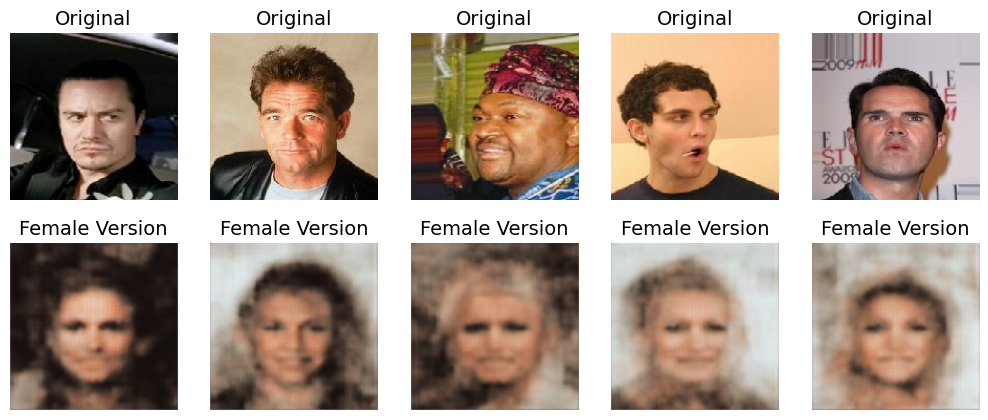

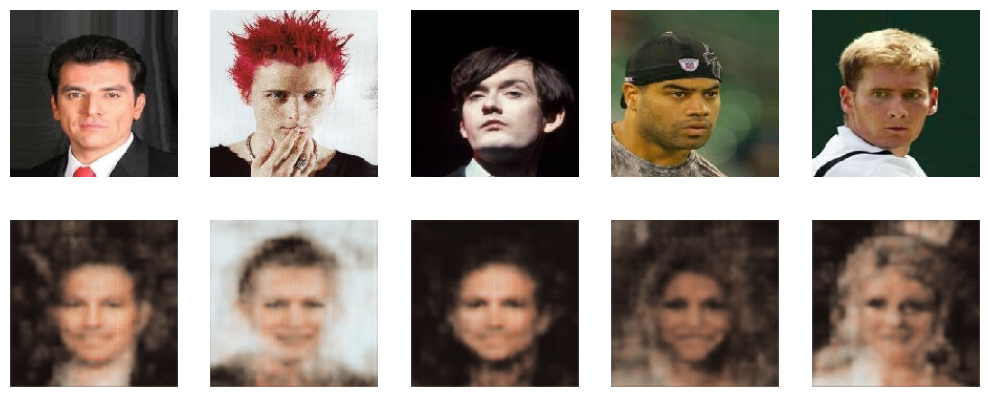

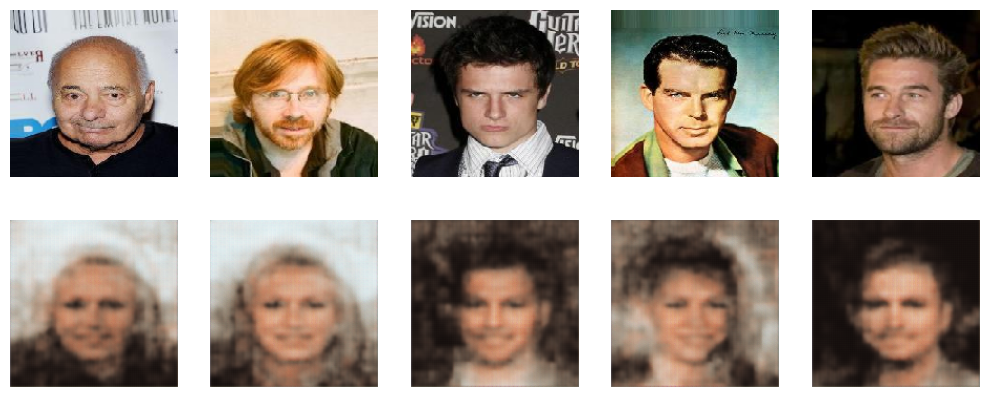

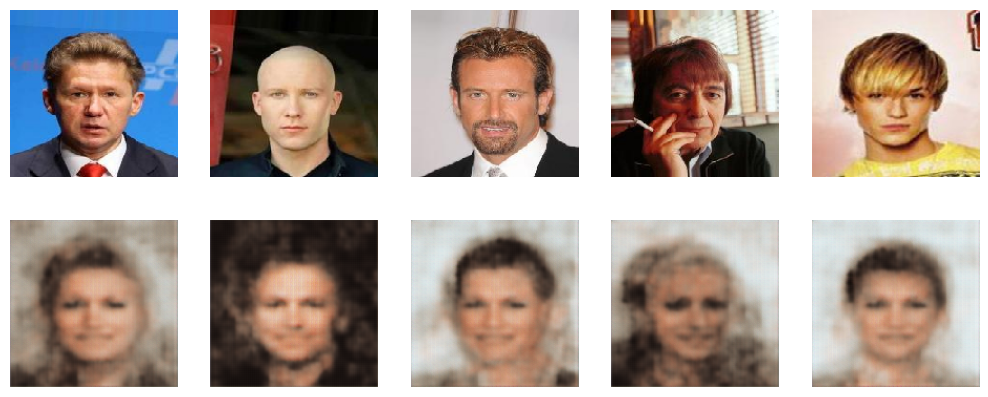

In [96]:
show_gender_conversion_simple(
    img_dir="/content/val/male",  # 或你要的路徑
    encoder=encoder,
    decoder=decoder,
    gender_vector=gender_vector,
    num_pairs=20
)

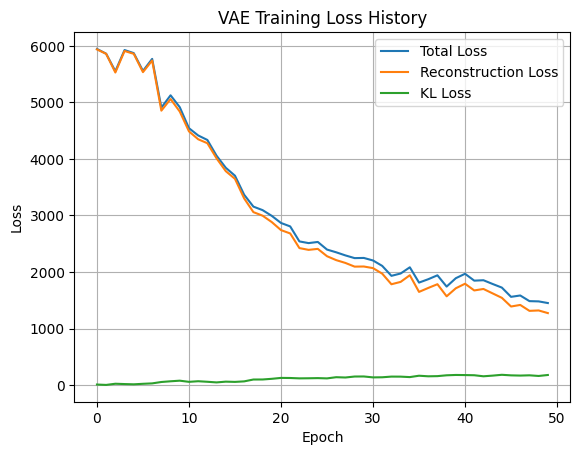

In [97]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"], label="Total Loss")
plt.plot(history.history["reconstruction_loss"], label="Reconstruction Loss")
plt.plot(history.history["kl_loss"], label="KL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("VAE Training Loss History")
plt.grid(True)
plt.show()

🚀 Extracting train latent vectors...
🚀 Extracting val latent vectors...
🔍 Running t-SNE...
🎨 Plotting...


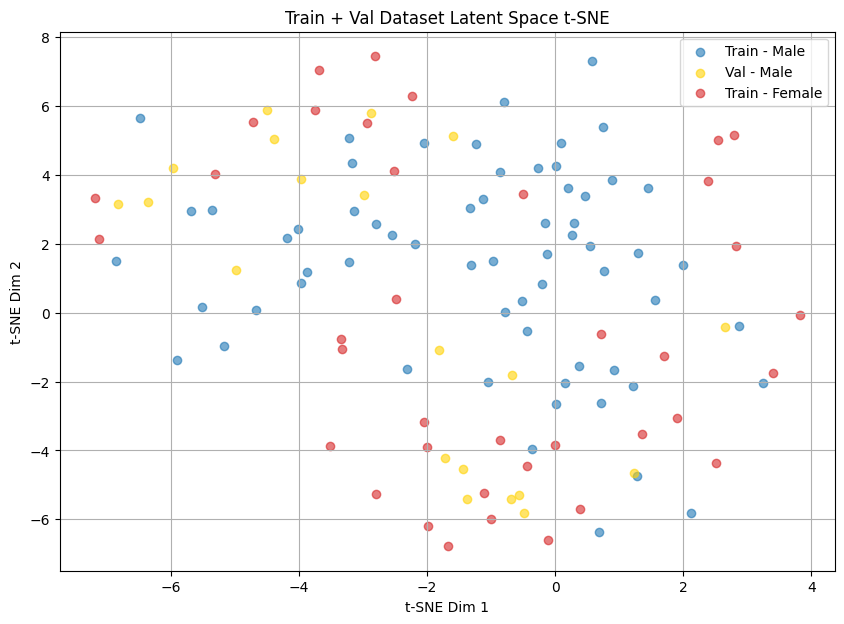

In [104]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

def extract_z_means_with_label(dataset, encoder, source_label):
    z_means = []
    labels = []
    sources = []
    for batch_x, batch_y in dataset:
        z_mean, _, _ = encoder.predict(batch_x, verbose=0)
        z_means.append(z_mean)
        labels.extend(batch_y.numpy())
        sources.extend([source_label] * len(batch_y))
    return np.concatenate(z_means, axis=0), np.array(labels), np.array(sources)

def draw_tsne_compare(train_dataset, val_dataset, encoder):
    print("🚀 Extracting train latent vectors...")
    z_train, label_train, source_train = extract_z_means_with_label(train_dataset, encoder, source_label='Train')
    print("🚀 Extracting val latent vectors...")
    z_val, label_val, source_val = extract_z_means_with_label(val_dataset, encoder, source_label='Val')

    # 合併所有 latent 向量
    z_all = np.concatenate([z_train, z_val], axis=0)
    labels_all = np.concatenate([label_train, label_val], axis=0)
    sources_all = np.concatenate([source_train, source_val], axis=0)

    print("🔍 Running t-SNE...")
    z_tsne = TSNE(n_components=2, random_state=42).fit_transform(z_all)

    print("🎨 Plotting...")
    plt.figure(figsize=(10, 7))

    # ✅ 自訂顏色
    color_map = {
        ('Train', 0): '#1f77b4',  # 藍色（Train - Male）
        ('Val',   0): '#ffd306',  # 黃色（Val - Male）
        ('Train', 1): '#d62728',  # 紅色（Train - Female）
        ('Val',   1): '#ff60af'   # 粉色（Val - Female) 不畫
    }

    for gender in [0, 1]:
        for source in ['Train', 'Val']:
            if gender == 1 and source == 'Val':
                continue  # 👈 排除 Val - Female
            mask = (labels_all == gender) & (sources_all == source)
            plt.scatter(
                z_tsne[mask, 0], z_tsne[mask, 1],
                label=f"{source} - {'Male' if gender==0 else 'Female'}",
                c=color_map[(source, gender)],
                alpha=0.6
            )

    plt.legend()
    plt.title("Train + Val Dataset Latent Space t-SNE")
    plt.xlabel("t-SNE Dim 1")
    plt.ylabel("t-SNE Dim 2")
    plt.grid(True)
    plt.show()

# ✅ 呼叫
draw_tsne_compare(train_dataset, val_dataset, encoder)